In [27]:
import geoopt
import torch as th
import numpy as np
from matplotlib import pyplot as plt
# %matplotlib notebook

from geoopt.manifolds.lorentz import Lorentz
from geoopt.manifolds.lorentz import math

from frechetmean import frechet_mean
from frechetmean import Lorentz as LorentzFrechet

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

plt.rcParams["font.family"] = "serif"

In [28]:
k = th.Tensor([1]) # choose curvature parameter
dim = 3

In [29]:
man = Lorentz(k=k)

In [30]:
# x = th.randn((2,dim)) # sample points (~N(0,1))
x = th.tensor([[-2.3571, 2.3689, 0]])
print(x)
x = man.projx(x) # project onto the hyperboloid
# x = x[:, 0:2]
x = man.expmap0(x)
print(x)


tensor([[-2.3571,  2.3689,  0.0000]])
tensor([[2.5713, 2.3689, 0.0000]])


In [31]:
# check if single point is in Hyperboloid
man._check_point_on_manifold(x[0,:])

(True, None)

/tmp/ipykernel_713069/544427362.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zz = np.sqrt((xx**2 + yy**2) + int(k.numpy()))


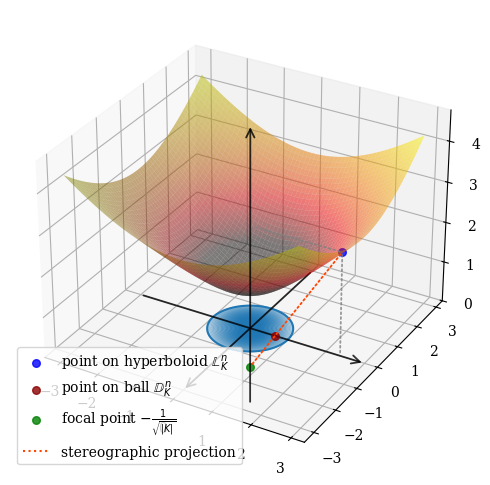

In [32]:
from cProfile import label
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
import sys
lw = 1.3

fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111, projection='3d',computed_zorder=False)
ax = fig.add_subplot(111, projection='3d')
# ax = fig.gca(projection='3d')


# plot hyperboloid
lim_ = 3
xx = np.arange(-lim_, lim_, 0.1)
yy = np.arange(-lim_, lim_, 0.1)
xx, yy = np.meshgrid(xx, yy)
zz = np.sqrt((xx**2 + yy**2) + int(k.numpy()))

point = th.zeros((1,3)) # sample points (~N(0,1))
point = man.projx(point) # project onto the hyperboloid

x_merge = np.concatenate((zz.flatten()[None], yy.flatten()[None], xx.flatten()[None]), axis=0).T

xcolors = man.dist(point, th.from_numpy(x_merge).to(th.float32)).view(*(xx.shape)).T.numpy()
xcolors = np.log(xcolors)

surf = ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, linewidth=0, alpha=0.5, facecolors=cm.hot(xcolors), zorder = 11)
# ax.scatter(point[:, 1], point[:, 2], point[:, 0], color="b", alpha = 0.9, s=30, label="North Pole")

# plot point on the hyperboloid and disk
ax.scatter(x[0,1], x[0,2], x[0,0], color="blue", alpha = 0.8, s=30, zorder = 12, label=r"point on hyperboloid $\mathbb{L}^{n}_K$")
point_disk = math.lorentz_to_poincare(x, k=k)
ax.scatter(point_disk[0,0], point_disk[0,1], 0., color="darkred", s=30, label=r"point on ball $\mathbb{D}^{n}_K$", zorder = 12, alpha = 0.8)

# plot circle
theta = np.linspace(0, 2*np.pi, 100)
r = np.sqrt(1.0)
x1 = r*np.cos(theta)
x2 = r*np.sin(theta)
point_zero = th.zeros((1,3)) # sample points (~N(0,1))
ax.plot(x1, x2, 0., color="C0",)
# ax.scatter(0., 0., 0., color="Red", alpha = 0.4, s=30, label="Origin")

for rad in np.arange(0., 1., 0.03):
    r = rad
    x1 = r*np.cos(theta)
    x2 = r*np.sin(theta)
    alpha = 1.2-rad
    if alpha > 1:
        alpha = 1
    ax.plot(x1, x2, 0., color="C0", alpha=alpha, zorder = -1)

# plot vertical axis
# zline = np.linspace(-3, 6, 100)
# xline = np.zeros_like(zline)
# yline = np.zeros_like(zline)
# ax.plot3D(xline, yline, zline, 'gray', lw = lw)

# plot arrow
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        # FancyArrowPatch.draw(self, renderer)
        return np.min(zs)

xs1 = [0,0]; ys1 = [0,0]; zs1 = [-2,5]
arw = Arrow3D([xs1[0],xs1[1]],[ys1[0],ys1[1]],[zs1[0],zs1[1]], arrowstyle="->", color="black", lw = lw, mutation_scale=15, alpha = 0.8, zorder = 10)
ax.add_patch(arw)
xs1 = [0,0]; ys1 = [3,-3]; zs1 = [0,0]
arw = Arrow3D([xs1[0],xs1[1]],[ys1[0],ys1[1]],[zs1[0],zs1[1]], arrowstyle="->", color="black", lw = lw, mutation_scale=15, alpha = 0.8, zorder = 10)
ax.add_patch(arw)
xs1 = [-3,3]; ys1 = [0,0]; zs1 = [0,0]
arw = Arrow3D([xs1[0],xs1[1]],[ys1[0],ys1[1]],[zs1[0],zs1[1]], arrowstyle="->", color="black", lw = lw, mutation_scale=15, alpha = 0.8, zorder = 10)
ax.add_patch(arw)

# hyperboloid to 1/sqrt(c)
xs1 = [x[0,1],0]; ys1 = [x[0,2],0]; zs1 = [x[0,0],-1]
arw = Arrow3D([xs1[0],xs1[1]],[ys1[0],ys1[1]],[zs1[0],zs1[1]], arrowstyle="-",linestyle="dotted", color="orangered", lw = lw, mutation_scale=15, alpha = 1, zorder = 9,)
ax.add_patch(arw)
ax.scatter(0, 0, -1, color="green", alpha = 0.8, s=30, label=r"focal point $-\frac{1}{\sqrt{|K|}}$", zorder = 11)
ax.plot([0],[0],[0],linestyle="dotted",color="orangered",label="stereographic projection")

# hyperboloid to z=0 plane
xs1 = [x[0,1],x[0,1]]; ys1 = [x[0,2],x[0,2]]; zs1 = [x[0,0],0]
arw = Arrow3D([xs1[0],xs1[1]],[ys1[0],ys1[1]],[zs1[0],zs1[1]], arrowstyle="-",linestyle="dotted", color="grey", lw = lw, mutation_scale=15, alpha = 0.8, zorder = 10)
ax.add_patch(arw)
xs1 = [x[0,1],0]; ys1 = [x[0,2],0]; zs1 = [x[0,0],x[0,0]]
arw = Arrow3D([xs1[0],xs1[1]],[ys1[0],ys1[1]],[zs1[0],zs1[1]], arrowstyle="-",linestyle="dotted", color="grey", lw = lw, mutation_scale=15, alpha = 0.8, zorder = 10)
ax.add_patch(arw)


ax.set_zlim(bottom=0)
plt.legend(loc = 'best')
# plt.title("Hyperbolic and projection to the disk")
# plt.savefig("./midpoints/{}.pdf".format("poincare_projection"), dpi=300, format="pdf")
plt.show()